***Important note:***  
The code for **training the GCN model** and **explaining its predictions** using **GNNExplainer** is based on the official PyTorch Geometric example, which can be found [here](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/gnn_explainer_link_pred.py).


# **Step 1: Install dependencies & import the necessary libraries**

In [1]:
#install the required dependencies for PyG
#https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

!pip install torch_geometric
!pip install torch
# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu124.html

!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
#import libraries
import os
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve, average_precision_score


import networkx as nx
from pyvis.network import Network

import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

# **Step 2: Load the graph in a Pandas df**

In [3]:
#read the csv file (our graph) and load it in a Pandas df for preprocessing
graph = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/Knowledge Graph Sample.csv')

graph.head(5)

,ENTITY_A,ENTITY_A_CUI,RELATION,ENTITY_B,JOURNAL_B,ENTITY_B_CUI_OR_ARTICLE_id
0,ATXN3 gene,C1538301,PREVENTS,Toxic effect,NaN,C0600688
1,Extraction,C0185115,PREVENTS,Urinary tract infection,NaN,C0042029
2,polyglutamine,C0384782,PREVENTS,Toxic effect,NaN,C0600688
3,Therapeutic procedure,C0087111,PREVENTS,Teratogenesis,NaN,C0232910
4,Therapeutic procedure,C0087111,PREVENTS,Abnormal mental state,NaN,C0278061


# **Step 3: Encoding and mapping the data**
In this step, we need to make the knowledge graph data compatible with GNNs. To do so, we will prepare them by encoding all the nodes and relations into numeric values.

In [4]:
#find the unique nodes
unique_nodes = pd.Series(pd.concat([graph['ENTITY_A_CUI'], graph['ENTITY_B_CUI_OR_ARTICLE_id']]).unique())
#unique_nodes.head(5)
print(f"Unique nodes in the graph: {unique_nodes.nunique()}")

Unique nodes in the graph: 191


In [5]:
#nodes
node_id_mapping = {node: idx + 1 for idx, node in enumerate(unique_nodes)} #{'C1538301': 1, 'C0185115': 2...}

#adding columns ENTITY_A_ID , ENTITY_B_ID with the numeric ids we created above
graph['ENTITY_A_ID'] = graph['ENTITY_A_CUI'].map(node_id_mapping)
graph['ENTITY_B_ID'] = graph['ENTITY_B_CUI_OR_ARTICLE_id'].map(node_id_mapping)

#relations
relation_mapping = {relation: idx + 1 for idx, relation in enumerate(graph['RELATION'].unique())}

#adding the RELATION_ENCODED column with the encoded relaition id
graph['RELATION_ENCODED'] = graph['RELATION'].map(relation_mapping)

graph.head(5)

,ENTITY_A,ENTITY_A_CUI,RELATION,ENTITY_B,JOURNAL_B,ENTITY_B_CUI_OR_ARTICLE_id,ENTITY_A_ID,ENTITY_B_ID,RELATION_ENCODED
0,ATXN3 gene,C1538301,PREVENTS,Toxic effect,NaN,C0600688,1,34,1
1,Extraction,C0185115,PREVENTS,Urinary tract infection,NaN,C0042029,2,35,1
2,polyglutamine,C0384782,PREVENTS,Toxic effect,NaN,C0600688,3,34,1
3,Therapeutic procedure,C0087111,PREVENTS,Teratogenesis,NaN,C0232910,4,36,1
4,Therapeutic procedure,C0087111,PREVENTS,Abnormal mental state,NaN,C0278061,4,37,1


# **Step 4: Creating the nodes and edges files for PyTorch Geometric**
The next steps include training a GCN model and then applying GNNExplainer. To do so, we need the following files to construct the graph in PyG:


1. **nodes.csv**
   * Mapping of node IDs to their labels
  
2. **edges.csv**
   * The relations between nodes



In [6]:
#declaring the output directory for storing the csv files
output_dir = "/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/small_graph_files"
os.makedirs(output_dir, exist_ok=True)

#nodes.csv
#map node IDs with their node labels
node_label_mapping = pd.concat([
    graph[['ENTITY_A_ID', 'ENTITY_A']].rename(columns={'ENTITY_A_ID': 'Node_ID', 'ENTITY_A': 'Node_Label'}),
    graph[['ENTITY_B_ID', 'ENTITY_B']].rename(columns={'ENTITY_B_ID': 'Node_ID', 'ENTITY_B': 'Node_Label'})
]).drop_duplicates()

node_label_mapping.to_csv(os.path.join(output_dir, "nodes.csv"), index=False, sep=" ")

edges_df = graph[['ENTITY_A_ID', 'ENTITY_B_ID', 'RELATION_ENCODED']].rename(
    columns={'ENTITY_A_ID': 'Source', 'ENTITY_B_ID': 'Target', 'RELATION_ENCODED': 'Relation_Label'}
)
edges_df.to_csv(os.path.join(output_dir, "edges.csv"), index=False)



# **Step 5: Preparing the data for the GCN model and the GNNExplainer**  
This step consists of processing the data in a suitable format for PyG.

In [7]:
#use GPU (CUDA) if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load the nodes and edges files
nodes_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/small_graph_files/nodes.csv", sep=" ")
edges_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/small_graph_files/edges.csv")

display(nodes_df)
display(edges_df)

,Node_ID,Node_Label
0,1,ATXN3 gene
1,2,Extraction
2,3,polyglutamine
3,4,Therapeutic procedure
4,5,Ophthalmic examination and evaluation
...,...,...
186,187,Mitochondrial mutation
187,188,"Adolescents, Female"
188,189,Neuroradiologist
189,190,Canis familiaris


,Source,Target,Relation_Label
0,1,34,1
1,2,35,1
2,3,34,1
3,4,36,1
4,4,37,1
...,...,...,...
288,29,44,10
289,30,44,10
290,31,44,10
291,32,52,10


In [8]:
#in PyTorch Geometric, node indices must be continuous, so we map them
node_mapping = {node_id: idx for idx, node_id in enumerate(nodes_df['Node_ID'])}

#apply the mapping to nodes_df, edges_df
nodes_df['Mapped_ID'] = nodes_df['Node_ID'].map(node_mapping)
edges_df['Source'] = edges_df['Source'].map(node_mapping)
edges_df['Target'] = edges_df['Target'].map(node_mapping)

#one-hot encoding representation of node features
#each row represents the unique node id
num_nodes = len(nodes_df)
x = torch.eye(num_nodes, dtype=torch.float)
print(x)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [9]:
#additional mappings for visualizations

#mapping of node labels - it's a reverse mapping (id -> node) to help with visualizations
# Fix node label mapping so that it starts from 1 instead of 0
node_label_mapping = {row['Mapped_ID'] + 1: row['Node_Label'] for _, row in nodes_df.iterrows()}



#mapping of relation labels - it's a reverse mapping (id -> relation) to help with visualizations
relation_label_mapping = {idx + 1: relation for idx, relation in enumerate(graph['RELATION'].unique())}

In [10]:
#convert the edges_df in a PyTorch tensor.
#we use .T to transpose the df to make it compatible with PyG (otherwise it won't get the correct shape)
edge_index = torch.tensor(edges_df[['Source', 'Target']].values.T, dtype=torch.long)

#all the edges in the graph are positive
edges_df['Label'] = 1
edge_labels = torch.tensor(edges_df['Label'].values, dtype=torch.long)

In [11]:
#to make edge_index and edge_label compatible with PyG, we assign it in "data", which is a PyG Data object
data = Data(x=x, edge_index=edge_index, edge_label=edge_labels).to(device)

#split data into train, validation, and test sets
#set automatic negative sampling to true, so that we have negative samples
transform = RandomLinkSplit(
    num_val=0.1,  #10% validation edges
    num_test=0.2,  #20% test edges
    is_undirected=True,
    add_negative_train_samples=True
)
train_data, val_data, test_data = transform(data)

In [12]:
print(f"train_data: {train_data}")
print(f"val_data: {val_data}")
print(f"test_data: {test_data}")

train_data: Data(x=[191, 191], edge_index=[2, 412], edge_label=[412], edge_label_index=[2, 412])
val_data: Data(x=[191, 191], edge_index=[2, 412], edge_label=[58], edge_label_index=[2, 58])
test_data: Data(x=[191, 191], edge_index=[2, 470], edge_label=[116], edge_label_index=[2, 116])


In [13]:
#lables are converted to binary values
#postivie samples = 1
#negative samples = 0

train_data.edge_label = (train_data.edge_label > 0).long()
val_data.edge_label = (val_data.edge_label > 0).long()
test_data.edge_label = (test_data.edge_label > 0).long()

#validate the above
print(f"Unique labels in train_data.edge_label: {train_data.edge_label.unique()}")
print(f"Unique labels in val_data.edge_label: {val_data.edge_label.unique()}")
print(f"Unique labels in test_data.edge_label: {test_data.edge_label.unique()}")

Unique labels in train_data.edge_label: tensor([0, 1], device='cuda:0')
Unique labels in val_data.edge_label: tensor([0, 1], device='cuda:0')
Unique labels in test_data.edge_label: tensor([0, 1], device='cuda:0')


# **Step 6: Definitions and initializations**

1. A Graph Convolutional Network (GCN) is defined with two layers
2. The GCN model, the Optimizer and the Loss function are initialized
3. The Training and Evaluation functions are defined
4. Negative edges are generated

In [14]:
#defining the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels): #initialize the model with two layers
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index): #pass node features through the layers with the ReLU activation function
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index): #perform dot product on node embeddings to predict if a link or not
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index): #call encode() and decode() to generate predictions
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index).view(-1)


In [15]:
#initialize the GCN with 128 hidden dimensions and 64 output dimensions
model = GCN(data.num_node_features, 128, 64).to(device)

#use Adam optimizer with learning rate 0.01
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

#use binary cross-entropy loss with logits
loss_fn = torch.nn.BCEWithLogitsLoss()

In [16]:
#training function
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index) #node embeddings
    out = model.decode(z, train_combined_edge_index).view(-1) #decodes edge predictions
    loss = loss_fn(out, train_combined_edge_labels) #compute the binary cross-entropy loss
    loss.backward() #gradent descent (backpropagation)
    optimizer.step()
    return float(loss)

In [17]:
#compute the AUC score for evaluating the model
@torch.no_grad()
def evaluate(data, edge_index, edge_labels):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, edge_index).sigmoid()  #to convert logits to probabilities

    #this is to make sure that the labels are binary and the predictions a probabilities
    y_true = edge_labels.cpu().numpy()
    y_score = out.cpu().numpy()

    assert set(y_true).issubset({0, 1}), "Labels must be binary (0 or 1)."
    assert (y_score >= 0).all() and (y_score <= 1).all(), "Predictions must be probabilities (0 to 1)."

    return roc_auc_score(y_true, y_score)

In [18]:
#generate random edges (they are non-existent) as negative samples to train the model
train_neg_edge_index = torch.randint(0, num_nodes, (2, train_data.edge_index.size(1)), dtype=torch.long).to(device)
train_combined_edge_index = torch.cat([train_data.edge_index, train_neg_edge_index], dim=1)
train_combined_edge_labels = torch.cat([
    torch.ones(train_data.edge_index.size(1), dtype=torch.float).to(device),
    torch.zeros(train_neg_edge_index.size(1), dtype=torch.float).to(device),
])

# **Step 7: Training the model**

In [19]:
#training loop
#runs for 200 epochs
#every 20 epochs, we evaluate the Validation AUC and Test AUC
for epoch in range(1, 201):
    loss = train(train_data)
    if epoch % 20 == 0:
        val_auc = evaluate(val_data, val_data.edge_label_index, val_data.edge_label)
        test_auc = evaluate(test_data, test_data.edge_label_index, test_data.edge_label)
        print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}")


Epoch: 20, Loss: 0.2846, Val AUC: 0.3615, Test AUC: 0.6691
Epoch: 40, Loss: 0.0771, Val AUC: 0.3335, Test AUC: 0.5693
Epoch: 60, Loss: 0.0185, Val AUC: 0.3448, Test AUC: 0.5532
Epoch: 80, Loss: 0.0111, Val AUC: 0.3728, Test AUC: 0.5650
Epoch: 100, Loss: 0.0102, Val AUC: 0.3829, Test AUC: 0.5690
Epoch: 120, Loss: 0.0099, Val AUC: 0.3841, Test AUC: 0.5684
Epoch: 140, Loss: 0.0098, Val AUC: 0.3805, Test AUC: 0.5650
Epoch: 160, Loss: 0.0097, Val AUC: 0.3829, Test AUC: 0.5657
Epoch: 180, Loss: 0.0096, Val AUC: 0.3817, Test AUC: 0.5630
Epoch: 200, Loss: 0.0100, Val AUC: 0.3728, Test AUC: 0.5602


# **Step 8: Providing explanations using GNNExplainer**
Providing explanations for a **specific edge**.

In [20]:
#the model's explanation configurations
model_config = ModelConfig(
    mode='binary_classification', #because we perform a link prediction task
    task_level='edge', #the explanations are focused on edges (link prediction task)
    return_type='raw',
)

#initializing GNNExplainer
explainer = Explainer(
    model=model,
    explanation_type='model',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes', #explains which node attributes are important for the predictions
    edge_mask_type='object', #explains which edges important for the predictions
    model_config=model_config,
)

#explain a specific edge
#GNNExplainer is applied to identidy important nodes and edges leading to the prediction
edge_index_to_explain = 12  #the ith +1 edge
edge_label_index = val_data.edge_label_index[:, edge_index_to_explain]

explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    edge_label_index=edge_label_index,
)
print(f"Explanations available: {explanation.available_explanations}")
#output of available_explanations: ['edge_mask', 'node_mask']
#this means that the explainer was able to identify the important edge and node features for the link prediction task

Explanations available: ['node_mask', 'edge_mask']


# **Step 9: Visualizing Explanations**

In [21]:
#find the top 10 influential edges for the link prediction task

#extract edge mask to see which edges are most important
edge_mask = explanation.edge_mask.cpu().detach().numpy()
top_edges_indices = np.argsort(edge_mask)[-10:].copy()

#edge pairs
top_edges = train_data.edge_index[:, top_edges_indices].cpu().numpy().T

print("Top 10 Most Important Edges:")
for i, (src, dst) in enumerate(top_edges):
    print(f"{i+1}. Edge ({src} → {dst}), Importance Score: {edge_mask[top_edges_indices[i]]:.4f}")

Top 10 Most Important Edges:
1. Edge (95 → 16), Importance Score: 0.5565
2. Edge (27 → 43), Importance Score: 0.6034
3. Edge (108 → 16), Importance Score: 0.6154
4. Edge (13 → 43), Importance Score: 0.6337
5. Edge (25 → 43), Importance Score: 0.6443
6. Edge (9 → 43), Importance Score: 0.6514
7. Edge (86 → 16), Importance Score: 0.6733
8. Edge (8 → 43), Importance Score: 0.6735
9. Edge (85 → 16), Importance Score: 0.7136
10. Edge (88 → 16), Importance Score: 0.8216


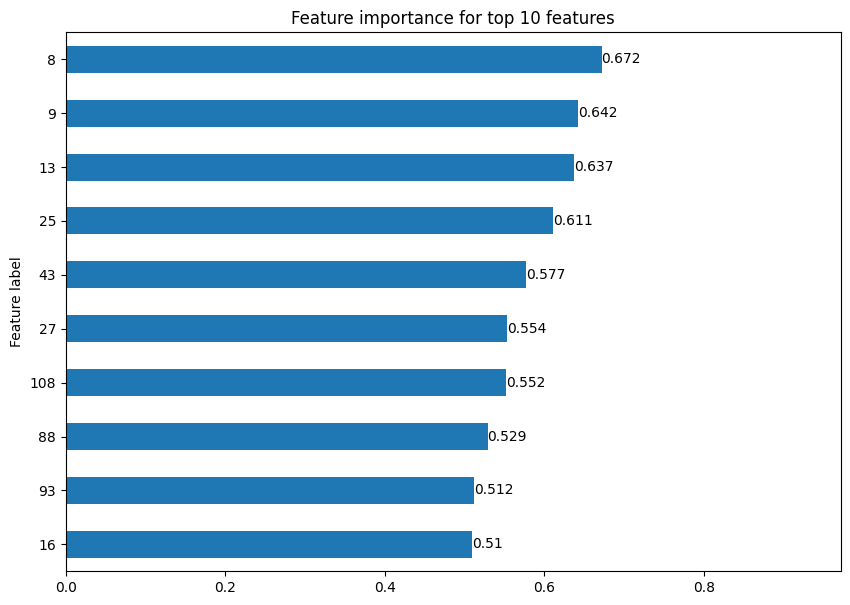

In [27]:
#Viz 1: Feature importance (the top 10 attributes (nodes))
explanation.visualize_feature_importance(top_k=10)

#PDF Viz: An explainability graph, where the key nodes and edges are highlighted
explanation.visualize_graph()

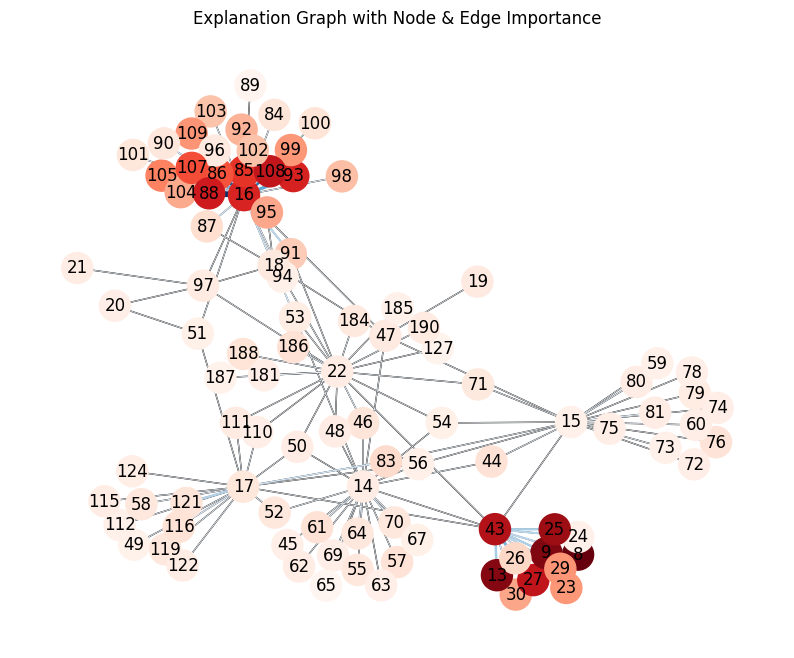

In [28]:
#Viz 2: Visualization of the graph with node and edge importance
#nodes: colored based on importance (node_mask)
#edges: thicker based on importance (edge_mask)

G = nx.Graph()

#EDGE IMPORTANCE
edges = train_data.edge_index.cpu().numpy().T
edge_mask = explanation.edge_mask.cpu().detach().numpy()

#loop through all edges and only add important edges (edge_mask > 0)
for i, (src, dst) in enumerate(edges):
    if edge_mask[i] > 0:
        G.add_edge(src, dst, weight=edge_mask[i])

#NODE IMPORTANCE
#for each node, sum importance across all feature dims
node_mask = explanation.node_mask.cpu().detach().numpy().sum(axis=1)
#dict to map the node indices with their importance score
node_importance = {i: node_mask[i] for i in range(len(node_mask))}

pos = nx.spring_layout(G, seed=42)
fig, ax = plt.subplots(figsize=(10, 8))

#draw nodes with importance-based color
node_colors = [node_importance.get(node, 0) for node in G.nodes()]
nx.draw(
    G, pos, with_labels=True, node_size=500, cmap=plt.cm.Reds, node_color=node_colors, ax=ax
)

#draw edges with importance-based width
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edge_collection = nx.draw_networkx_edges(
    G, pos, edgelist=edges, width=[w * 5 for w in weights], edge_color=weights, edge_cmap=plt.cm.Blues, ax=ax
)

plt.title("Explanation Graph with Node & Edge Importance")
plt.show()


In [29]:
#Viz 3 - INTERACTIVE: Visualization of the graph with node/edge importance and node/edge labels

def visualize_graph(top_n_nodes=20):
    G = nx.Graph()

    #EDGE IMPORTANCE
    edges = train_data.edge_index.cpu().numpy().T
    edge_mask = explanation.edge_mask.cpu().detach().numpy()

    #NODE IMPORTANCE (top N nodes)
    node_importance = explanation.node_mask.cpu().detach().numpy().sum(axis=1)
    important_nodes = np.argsort(node_importance)[-top_n_nodes:]

    #loop through all edges and only add important edges (edge_mask > 0)
    for i, (src, dst) in enumerate(edges):
        if edge_mask[i] > 0 and src in important_nodes and dst in important_nodes:
            G.add_edge(src, dst, weight=edge_mask[i])

    #error handling
    if len(G.edges) == 0:
        print("No edges available for this number of nodes.")
        return

    node_importance_dict = {i: node_importance[i] for i in important_nodes}

    #mapping of node labels and edge labels
    node_labels = {node: node_label_mapping.get(node, f"NaN {node}") for node in G.nodes()}
    edge_labels = {}
    for i, (src, dst) in enumerate(edges):
        if edge_mask[i] > 0 and src in important_nodes and dst in important_nodes:
            relation_id = edges_df.iloc[i]['Relation_Label'] if i < len(edges_df) else None
            relation_text = relation_label_mapping.get(relation_id, "NaN")

            edge_labels[(src, dst)] = relation_text


    pos = nx.spring_layout(G, seed=42)
    fig, ax = plt.subplots(figsize=(12, 8))

    node_colors = [node_importance_dict.get(node, 0) for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=True, labels=node_labels, node_size=800, cmap=plt.cm.Reds,
        node_color=node_colors, font_size=10, font_weight='bold', ax=ax
    )

    if len(G.edges) > 0:
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw_networkx_edges(
            G, pos, edgelist=edges, width=[w * 5 for w in weights],
            edge_color=weights, edge_cmap=plt.cm.Blues, ax=ax, alpha=0.7
        )

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax, font_weight='bold')

    plt.title("Explanation Graph with node/edge importance and node/edge labels", fontsize=14)
    plt.show()

#node slider to let us choose the number of nodes
node_slider = widgets.IntSlider(value=20, min=5, max=100, step=5, description='Top N Nodes')
widgets.interactive(visualize_graph, top_n_nodes=node_slider)


interactive(children=(IntSlider(value=20, description='Top N Nodes', min=5, step=5), Output()), _dom_classes=(…

In [30]:
#Viz 4 - INTERACTIVE HTML graph visualization with node & edge labels
def visualize_graph_pyvis(top_n_nodes=20, output_file="interactive_graph.html"):
    G = nx.Graph()

    #EDGE IMPORTANCE
    edges = train_data.edge_index.cpu().numpy().T
    edge_mask = explanation.edge_mask.cpu().detach().numpy()

    #NODE IMPORTANCE (top N nodes)
    node_importance = explanation.node_mask.cpu().detach().numpy().sum(axis=1)

    important_nodes = np.argsort(node_importance)[-top_n_nodes:]
    #top 10% most important nodes
    top_10_percent = important_nodes[-max(1, int(0.1 * len(important_nodes))):]

    #loop through all edges and only add important edges (edge_mask > 0)
    edge_labels = {}
    for i, (src, dst) in enumerate(edges):
        if edge_mask[i] > 0 and src in important_nodes and dst in important_nodes:
            G.add_edge(int(src), int(dst), weight=edge_mask[i])

            #edge labels
            relation_id = edges_df.iloc[i]['Relation_Label'] if i < len(edges_df) else None
            relation_text = relation_label_mapping.get(relation_id, f"Relation {relation_id}")
            edge_labels[(int(src), int(dst))] = relation_text


    #PyVis Network
    net = Network(height="100vh", width="100vw", bgcolor="white", font_color="black", cdn_resources="remote")

    net.barnes_hut(
        gravity=-5000, #to make it bouncy
        central_gravity=0.1,
        spring_length=250,
        spring_strength=0.008,
        damping=0.09,
        overlap=0.5 #so that nodes don't overlap
    )


    colors = {
        "most_important": "#D72638", #red (10%)
        "moderately_important": "#F46036", #orange (30%)
        "neutral": "#B0B0B0" #rest
    }

    #
    for node in G.nodes():
        node_id = int(node)
        node_label = node_label_mapping.get(node_id, f"Node {node_id}")
        importance = node_importance[node_id]

        node_size = 15 + (importance * 80)


        if node_id in top_10_percent:
            node_color = colors["most_important"]
        elif node_id in important_nodes[-max(1, int(0.3 * len(important_nodes))):]:
            node_color = colors["moderately_important"]
        else:
            node_color = colors["neutral"]

        net.add_node(
            node_id, label=node_label, size=node_size, color=node_color,
            font={"size": 18, "color": "black", "bold": True}
        )


    for (src, dst, weight) in G.edges(data=True):
        src, dst = int(src), int(dst)
        importance = weight["weight"]
        edge_color = f"rgb({255 - int(importance * 255)}, {255 - int(importance * 255)}, 255)"  #blue
        edge_width = 1 + (importance * 5) #thickness

        edge_label = edge_labels.get((src, dst), "NaN")

        net.add_edge(
            src, dst, width=edge_width, color=edge_color,
            title=edge_label, label=edge_label, font={"size": 14, "color": "black", "bold": True}
        )

    net.save_graph(output_file)
    print(f"Graph saved as: {output_file}")

visualize_graph_pyvis(top_n_nodes=20)


Graph saved as: interactive_graph.html


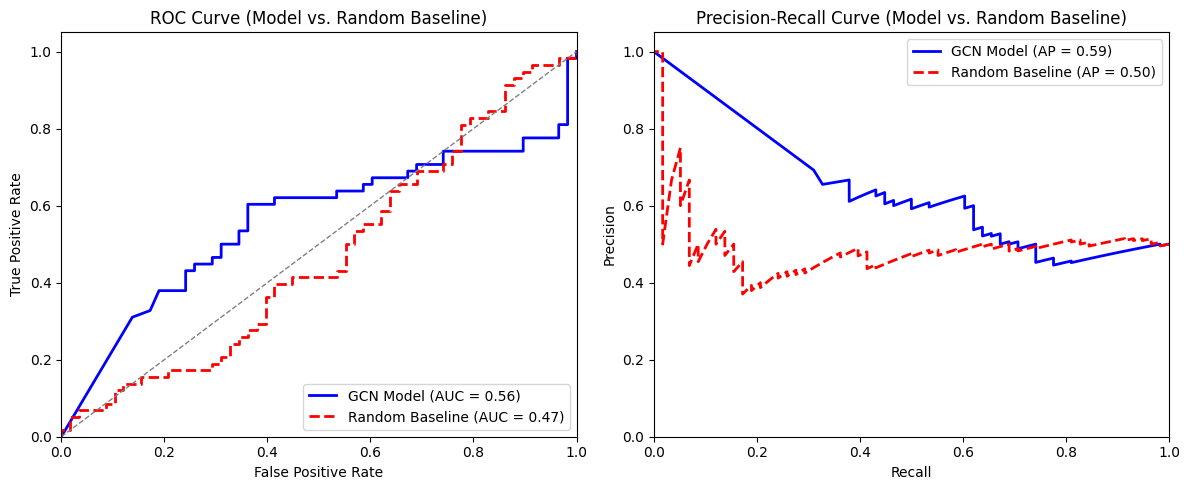

In [31]:
#Vis 5: ROC, Precision-Recall curve and baseline comparison with a random edge predictor, to evaluate the performance of the GCN model

#true labels and predicted probs
test_true = test_data.edge_label.cpu().numpy()
test_pred = model.decode(model.encode(test_data.x, test_data.edge_index),
                         test_data.edge_label_index).sigmoid().cpu().detach().numpy()

#ROC curve
fpr, tpr, _ = roc_curve(test_true, test_pred)
roc_auc = auc(fpr, tpr)

#PR curve
precision, recall, _ = precision_recall_curve(test_true, test_pred)
average_precision = average_precision_score(test_true, test_pred)

#generate random baseline predictions
random_preds = np.random.rand(len(test_true))
fpr_random, tpr_random, _ = roc_curve(test_true, random_preds)
roc_auc_random = auc(fpr_random, tpr_random)

precision_random, recall_random, _ = precision_recall_curve(test_true, random_preds)
average_precision_random = average_precision_score(test_true, random_preds)

#AUC-ROC Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'GCN Model (AUC = {roc_auc:.2f})')
plt.plot(fpr_random, tpr_random, color='red', linestyle='--', lw=2, label=f'Random Baseline (AUC = {roc_auc_random:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Model vs. Random Baseline)')
plt.legend(loc="lower right")

#Precision-Recall (PR) Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'GCN Model (AP = {average_precision:.2f})')
plt.plot(recall_random, precision_random, color='red', linestyle='--', lw=2, label=f'Random Baseline (AP = {average_precision_random:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Model vs. Random Baseline)')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()
